Размер до чистки: (344, 7)
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  

Пропущенные значения:
 species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
Размер после чистки: (333, 7)
Лучшее k: 9
Средняя точность (валидация): 0.996

Точность на тесте: 1.0

Классификационный отчёт:
               precision    recall  f1-score 

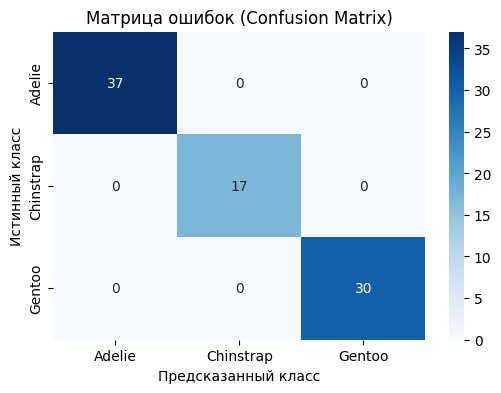

In [ ]:
# Если нужно: !pip install scikit-learn pandas seaborn matplotlib --quiet
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загрузка датасета по прямому URL                                         #
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(url)
print("Размер до чистки:", df.shape)

# 2. Быстрый взгляд на данные и чистка                                        #
print(df.head())
print("\nПропущенные значения:\n", df.isna().sum())

# Удаляем строки с пропусками (их немного, поэтому не страшно потерять)
df = df.dropna()
print("Размер после чистки:", df.shape)

# 3. Разделяем признаки X и целевой столбец y                                 #
X = df.drop("species", axis=1)   # все, кроме целевого
y = df["species"]                # целевой столбец

# 4. One-Hot кодируем категориальные признаки (island, sex)                   #
X = pd.get_dummies(X, drop_first=True)


# 5. Делим данные на обучающую и тестовую части                               #
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,        # 25 % на тест
    random_state=42,       # воспроизводимость
    stratify=y             # сохраняем пропорции классов
)

# 6. Создаём Pipeline: масштабирование → KNN                                  #
pipe = Pipeline([
    ("scaler", StandardScaler()),           # приводим признаки к N(0,1)
    ("knn", KNeighborsClassifier())         # сам классификатор
])

# 7. Подбираем оптимальное k с помощью GridSearch + кросс-валидации           #
param_grid = {"knn__n_neighbors": list(range(3, 16, 2))}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Лучшее k:", grid.best_params_["knn__n_neighbors"])
print("Средняя точность (валидация):", round(grid.best_score_, 3))

# 8. Оцениваем качество на тестовой выборке                                   #
y_pred = grid.predict(X_test)
print("\nТочность на тесте:", round(accuracy_score(y_test, y_pred), 3))
print("\nКлассификационный отчёт:\n", classification_report(y_test, y_pred))

# 9. Строим и визуализируем Confusion Matrix                                  #
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=grid.classes_,
    yticklabels=grid.classes_
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()
